<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/hypotension_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [ ]:
!pip install vitaldb
import vitaldb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 704 kB/s 
     |████████████████████████████████| 161 kB 9.3 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 9.1 MB 49.5 MB/s 
     |████████████████████████████████| 127 kB 27.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
df_cases.head()

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100


In [3]:
df_trks.head()

,caseid,tname,tid
0,1,BIS/BIS,fd869e25ba82a66cc95b38ed47110bf4f14bb368
1,1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
2,1,BIS/EEG2_WAV,ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3,1,BIS/EMG,2525603efe18d982764dbca457affe7a45e766a9
4,1,BIS/SEF,1c91aec859304840dec75acf4a35da78be0e8ef0


## Case Selection

In [2]:
# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3312 cases found


In [5]:
caseids

[6388,
 872,
 93,
 4409,
 4859,
 3906,
 5692,
 476,
 2194,
 2935,
 1216,
 3691,
 3736,
 2982,
 108,
 6117,
 5517,
 513,
 1735,
 5471,
 4477,
 2083,
 2695,
 1240,
 5274,
 4371,
 1846,
 1955,
 4772,
 4591,
 1300,
 5486,
 2631,
 2420,
 6027,
 4170,
 303,
 817,
 4098,
 5126,
 5568,
 2868,
 4674,
 5010,
 32,
 200,
 812,
 2242,
 5819,
 6102,
 413,
 2820,
 2299,
 703,
 203,
 4564,
 5650,
 1185,
 853,
 5597,
 3709,
 848,
 4538,
 4178,
 4957,
 2305,
 1465,
 4730,
 6250,
 3098,
 781,
 1344,
 4572,
 4148,
 1567,
 5805,
 4128,
 6060,
 4609,
 3987,
 4771,
 2187,
 5899,
 2580,
 4426,
 1733,
 1966,
 3219,
 3842,
 688,
 1810,
 5872,
 5680,
 149,
 1978,
 4729,
 561,
 2774,
 827,
 5593,
 5110,
 221,
 6127,
 308,
 1223,
 5722,
 4601,
 4352,
 202,
 5326,
 5221,
 3739,
 3879,
 1894,
 208,
 3080,
 4014,
 4028,
 6022,
 3732,
 5817,
 2060,
 438,
 890,
 3704,
 4716,
 2891,
 2422,
 3276,
 4203,
 242,
 3122,
 3369,
 4251,
 3312,
 2854,
 464,
 5585,
 992,
 4519,
 3376,
 2673,
 2206,
 3776,
 6128,
 5646,
 4546,
 5

## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

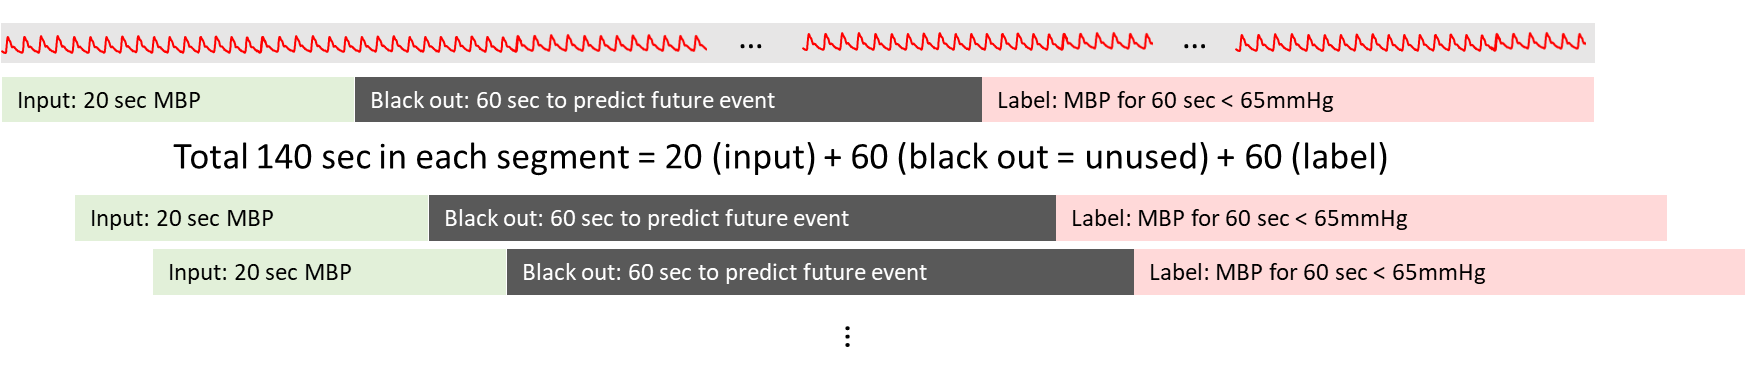

In [12]:

from tqdm.notebook import tqdm

MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in tqdm(caseids):
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * SRATE  
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]  

print(x.shape)
print(y.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

loading 32...no sample
loading 93...191 samples 42 (22.0 %) events
loading 108...732 samples 142 (19.4 %) events
loading 149...1010 samples 4 (0.4 %) events
loading 200...690 samples 0 (0.0 %) events
loading 203...424 samples 137 (32.3 %) events
loading 303...1495 samples 0 (0.0 %) events
loading 413...437 samples 0 (0.0 %) events
loading 476...1427 samples 39 (2.7 %) events
loading 513...913 samples 1 (0.1 %) events
loading 561...270 samples 30 (11.1 %) events
loading 688...no sample
loading 703...962 samples 64 (6.7 %) events
loading 781...470 samples 137 (29.1 %) events
loading 812...754 samples 0 (0.0 %) events
loading 817...no sample
loading 827...651 samples 0 (0.0 %) events
loading 848...765 samples 0 (0.0 %) events
loading 853...891 samples 16 (1.8 %) events
loading 872...1449 samples 0 (0.0 %) events
loading 1185...1587 samples 37 (2.3 %) events
loading 1216...2774 samples 34 (1.2 %) events
loading 1240...1174 samples 3 (0.3 %) events
loading 1300...282 samples 15 (5.3 %) even

## Splitting samples into training and testing dataset


In [13]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100cases 1ahead batchsize=256 total 120997, train 72405 (1904 events 2.6%), test 16681 (688 events 4.1%)


## Model building and training

In [18]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in tqdm(CNN_LAYERS):
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
254/255 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9477 - auc_2: 0.9569
Epoch 1: val_loss improved from inf to 0.01936, saving model to output/weights.hdf5
255/255 [==============================] - 28s 86ms/step - loss: 0.1928 - accuracy: 0.9477 - auc_2: 0.9568 - val_loss: 0.0194 - val_accuracy: 0.9960 - val_auc_2: 0.9836
Epoch 2/100
254/255 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9554 - auc_2: 0.9679
Epoch 2: val_loss improved from 0.01936 to 0.01489, saving model to output/weights.hdf5
255/255 [==============================] - 22s 85ms/step - loss: 0.1637 - accuracy: 0.9554 - auc_2: 0.9679 - val_loss: 0.0149 - val_accuracy: 0.9960 - val_auc_2: 0.9887
Epoch 3/100
254/255 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9559 - auc_2: 0.9693
Epoch 3: val_loss did not improve from 0.01489
255/255 [==============================] - 21s 83ms/step - loss: 0.1601 - accuracy: 0.9559 - auc_2: 0.96

9326

## Evaluation of the model performance

In [15]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_p = model.predict(test_x, BATCH_SIZE).flatten()
test_p_valid = test_p[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_p_valid)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_p_valid)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_p_valid > thval)
acc = accuracy_score(test_y_valid, test_p_valid > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_p_valid > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

92/92 [==============================] - 2s 23ms/step
auroc=0.968, auprc=0.588 acc=0.969, F1=0.541, PPV=70.8, NPV=97.6, TN=15869, fp=124, fn=387, TP=301


## Plotting each case in the test dataset

5274	1.8397498419984142e-05	


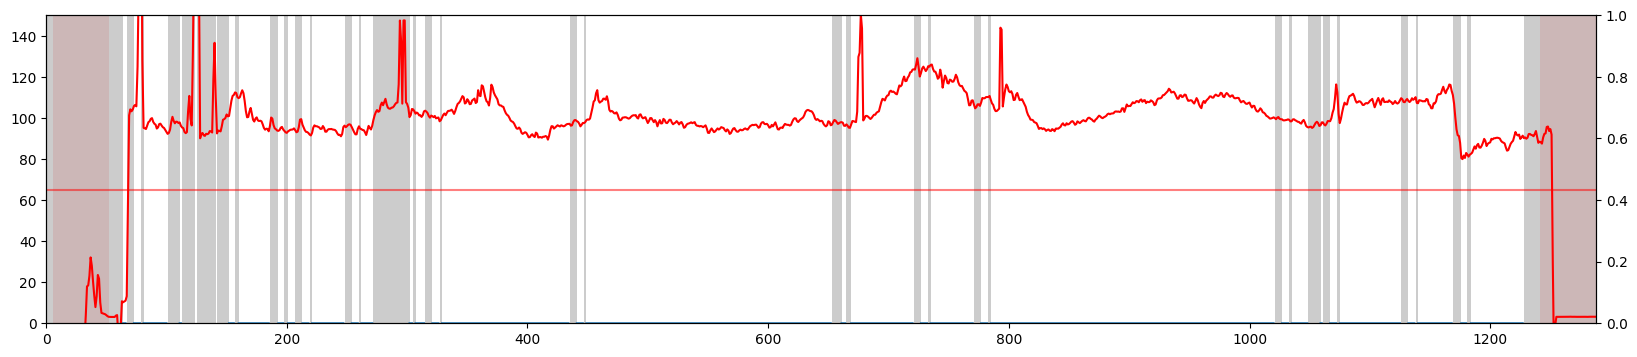

5486	0.17916656737176967	


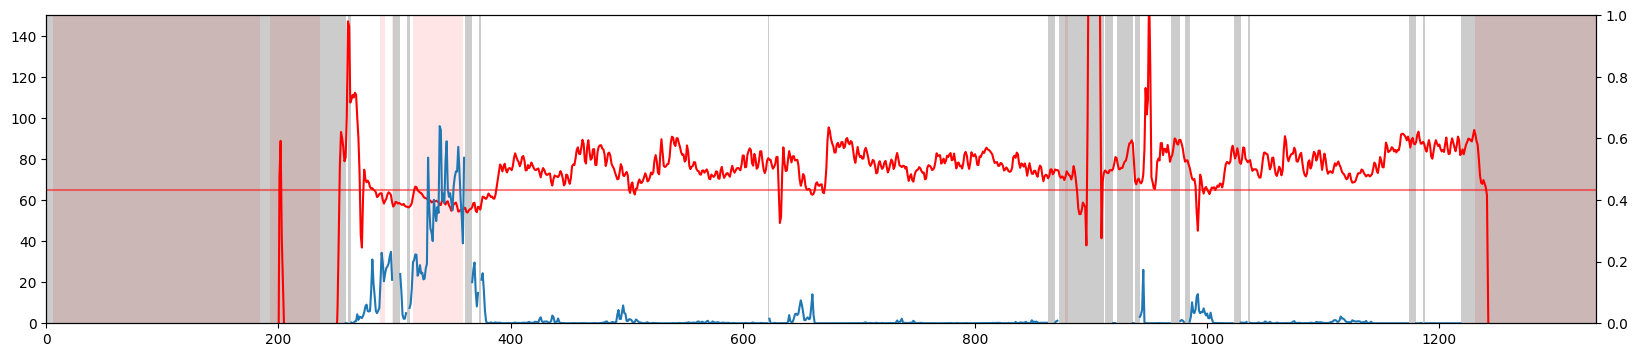

5517	0.07092816961575878	


<ipython-input-16-9367ec9924db>:34: RuntimeWarning: Mean of empty slice
  ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')


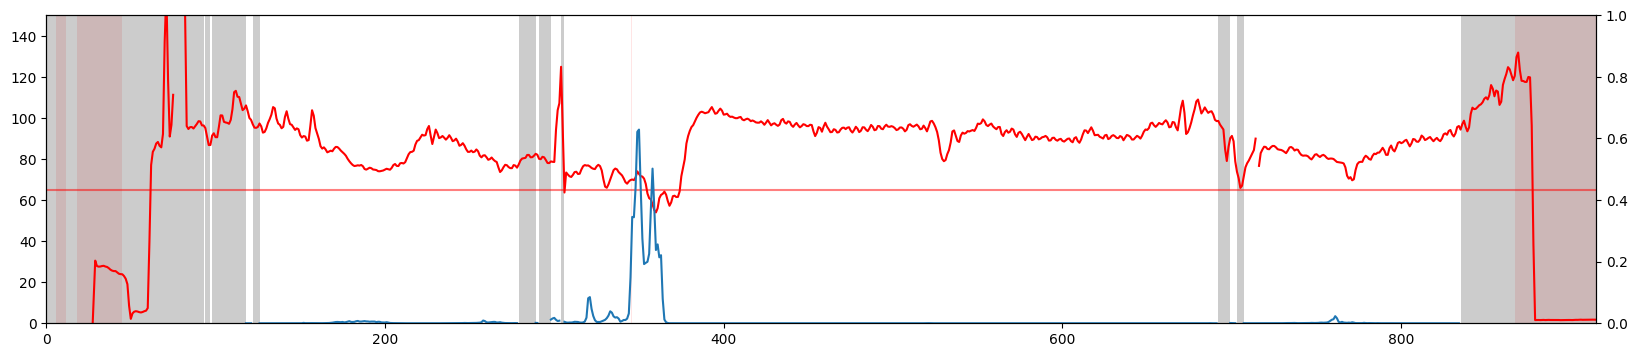

5568	0.2601775581637671	


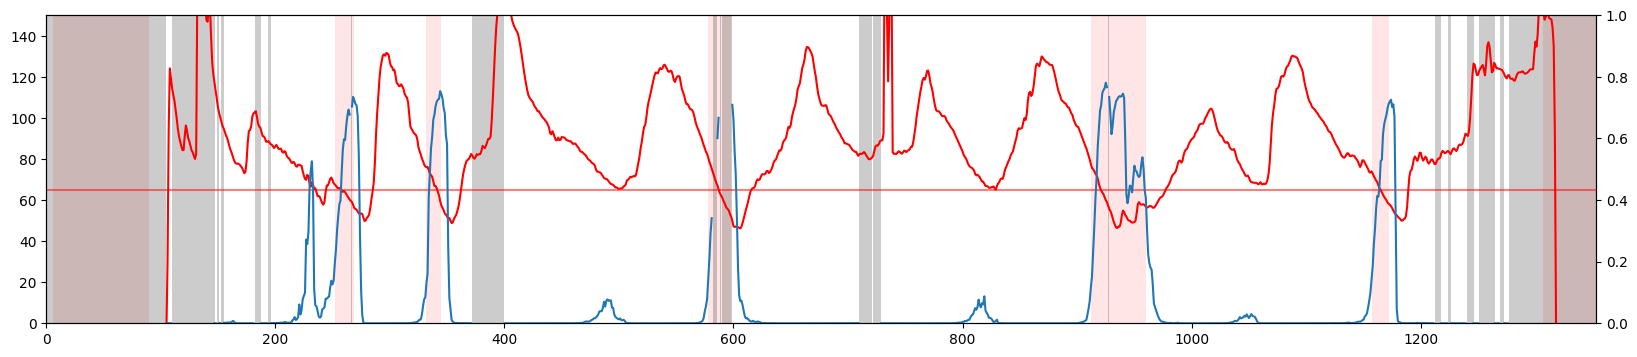

5593	0.028329123367834545	


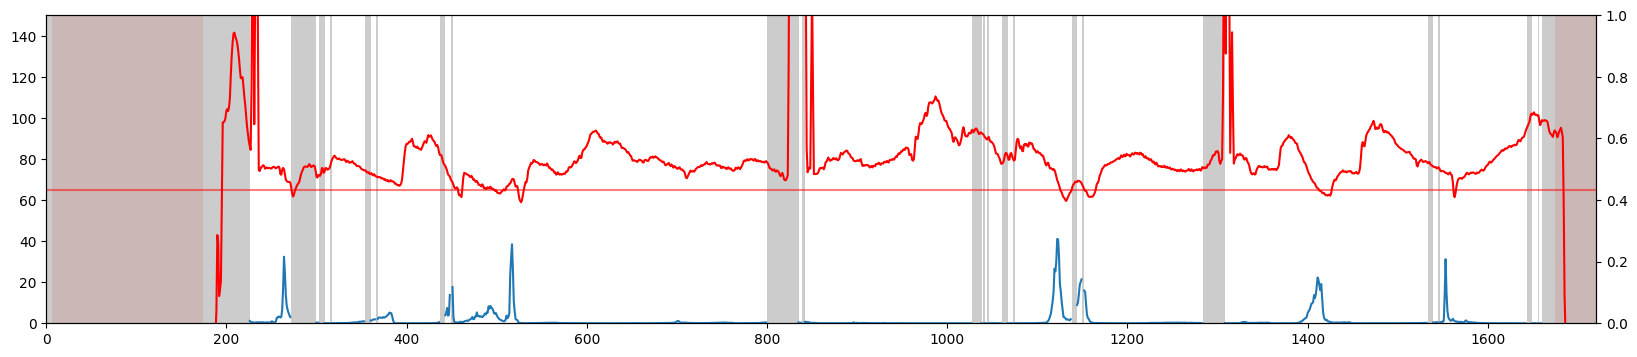

5597	0.180852358869404	


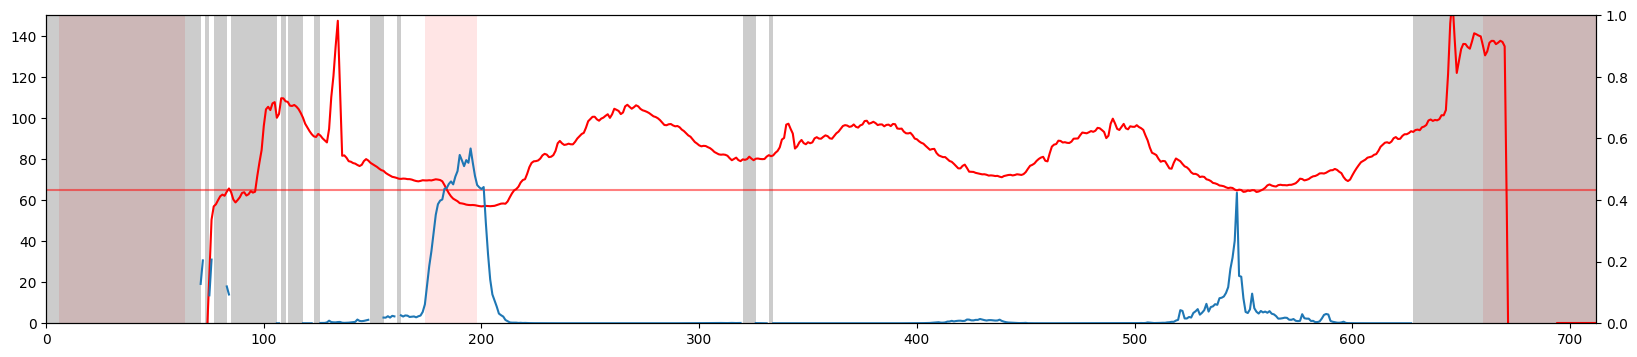

5650	0.32463388407848476	


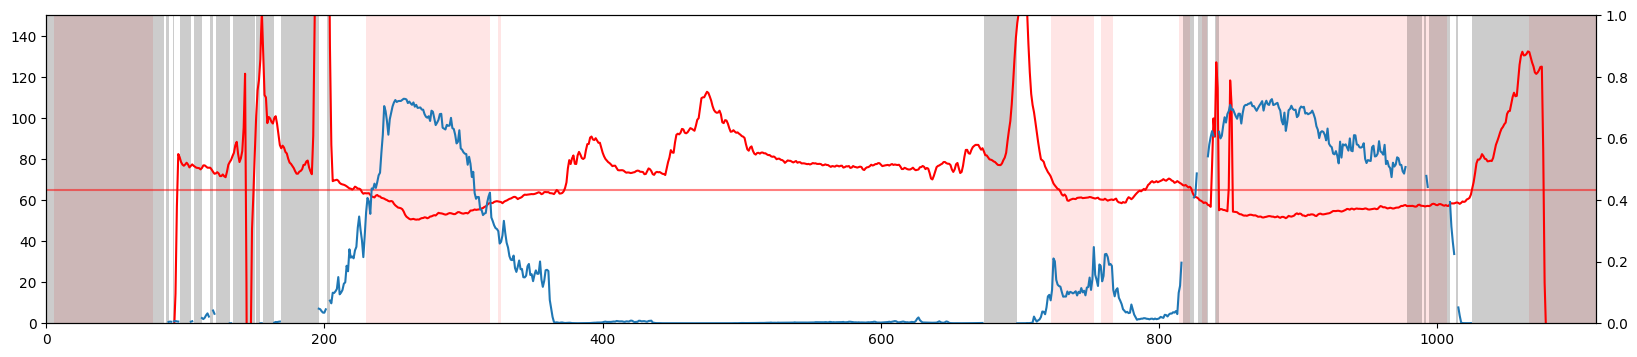

5680	0.006311880044533101	


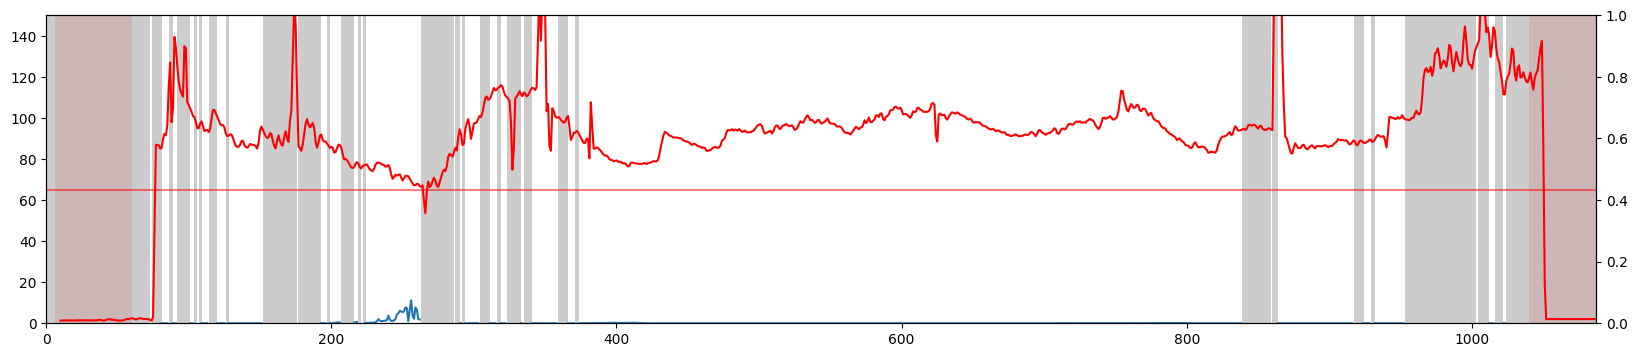

5692	0.0008034938871142212	


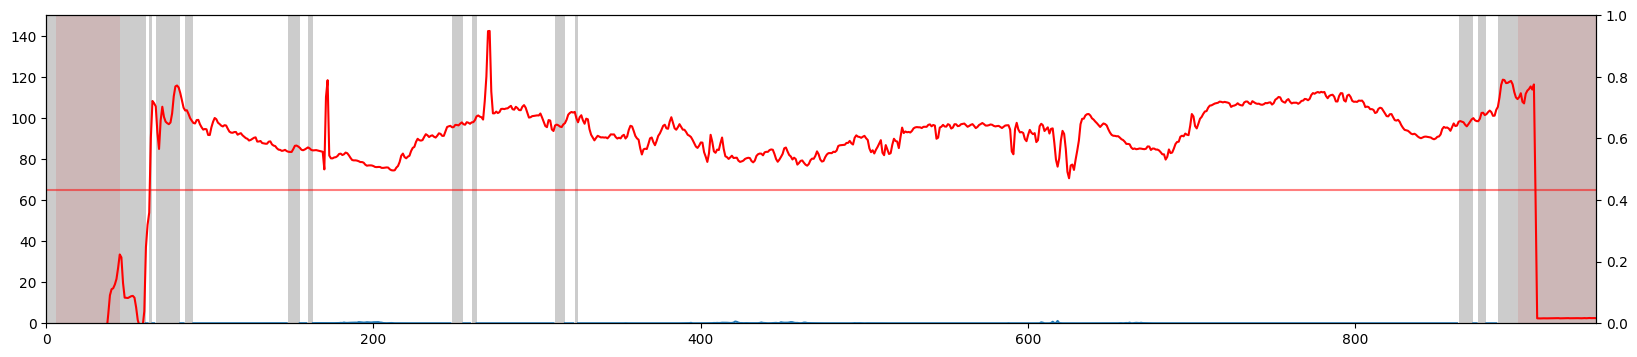

5805	0.31197039311108216	


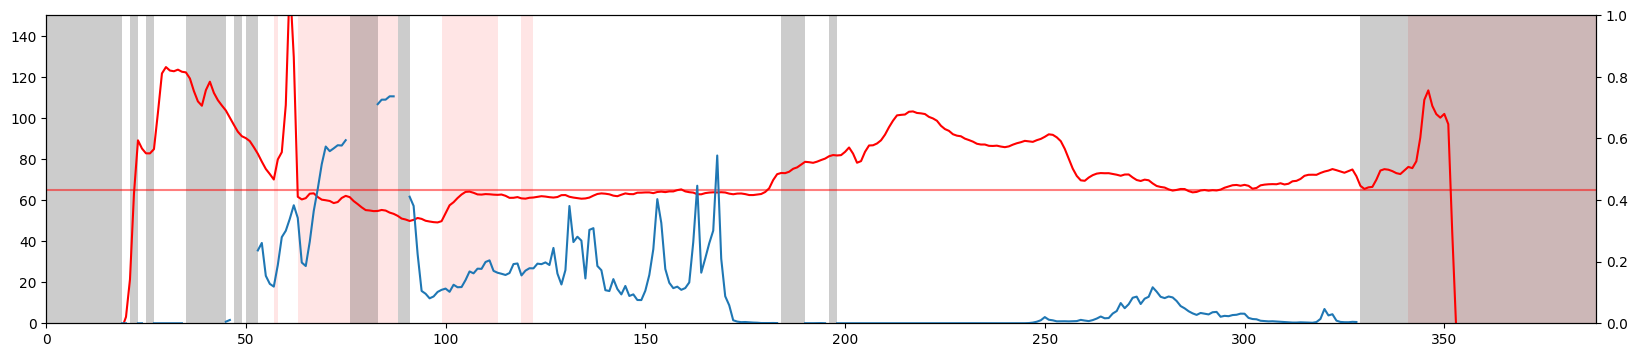

5819	0.10148532851566326	


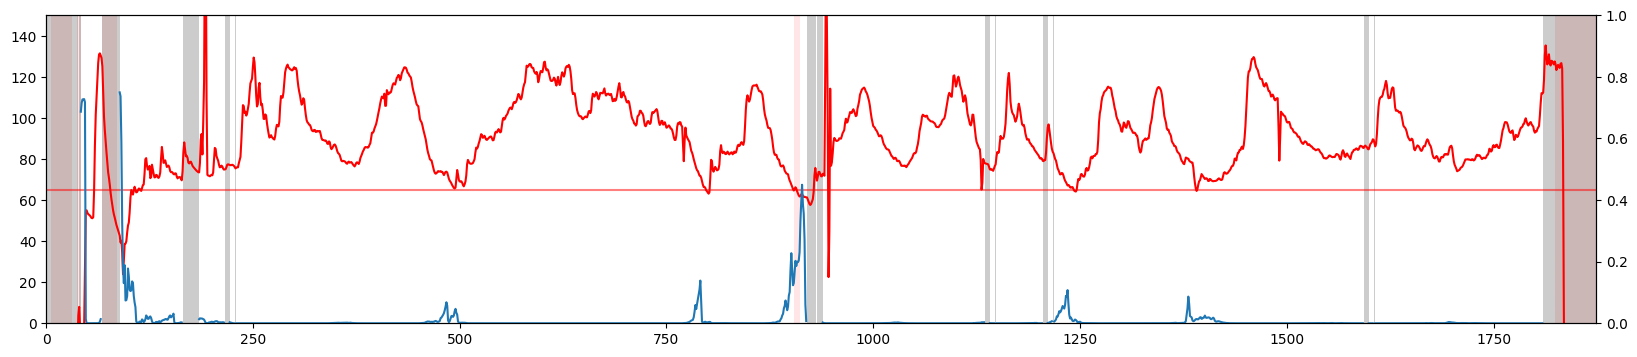

5872	0.07944676345631604	


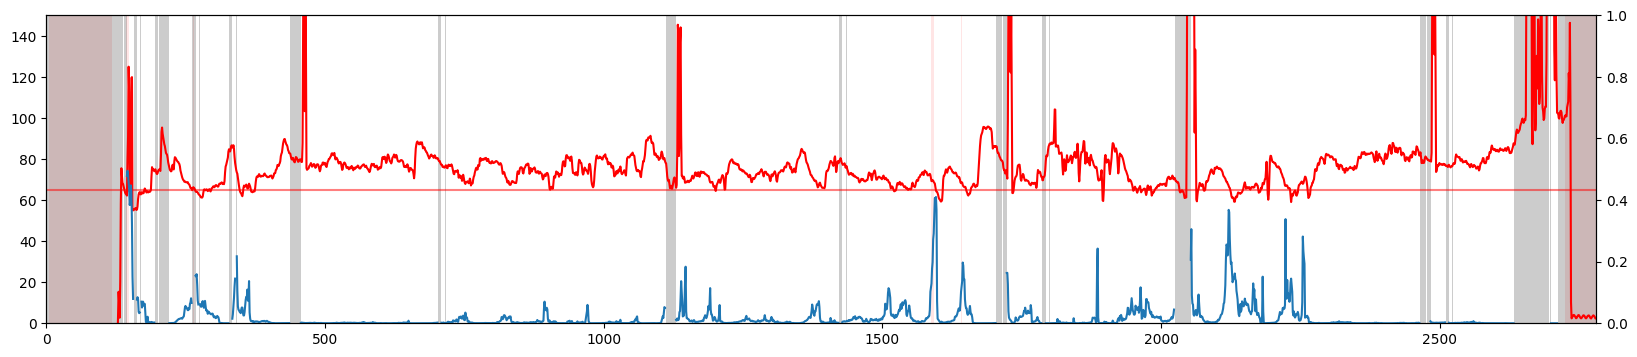

6027	0.016240477649015858	


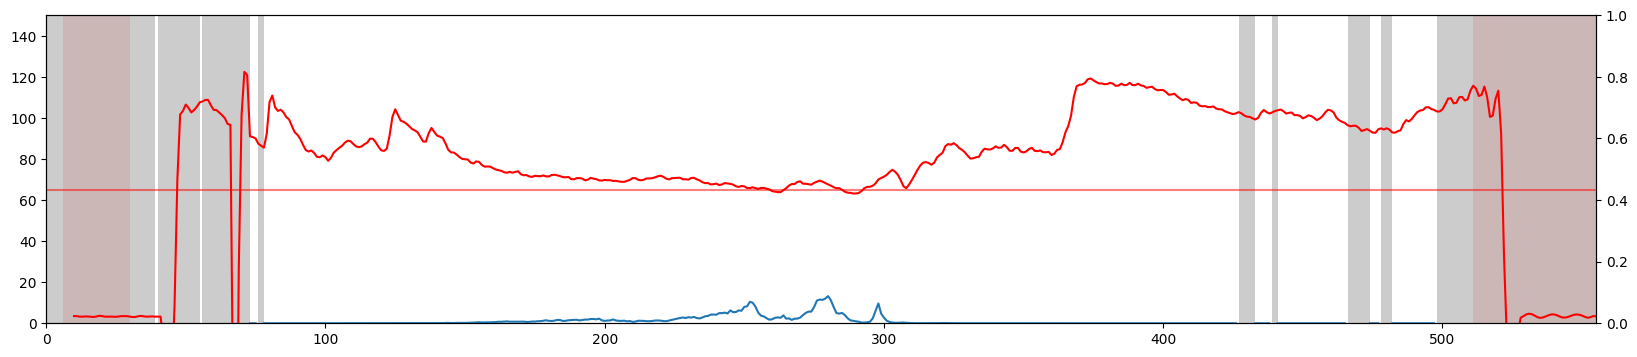

6060	0.001885521028987055	


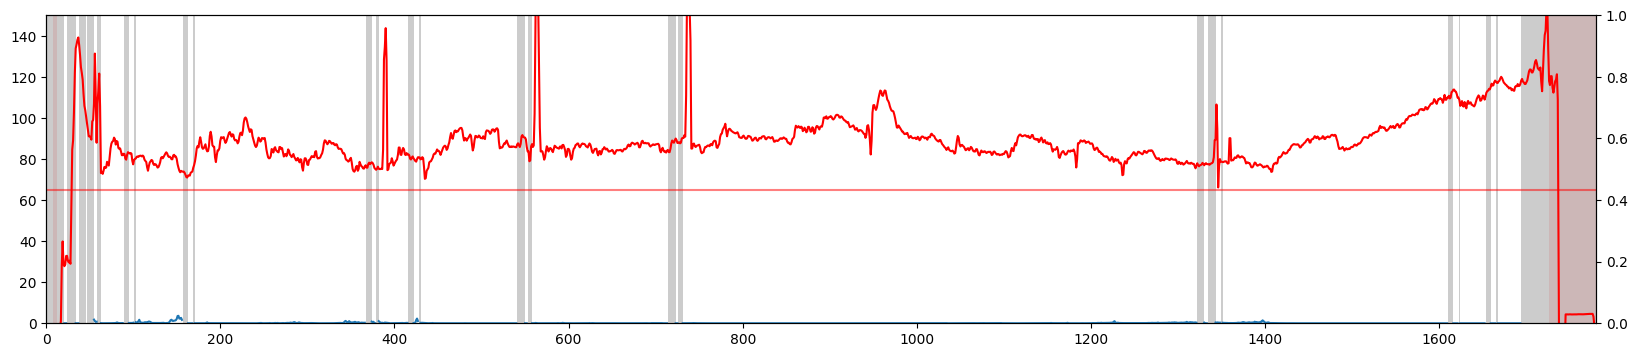

6102	0.32380853692644496	


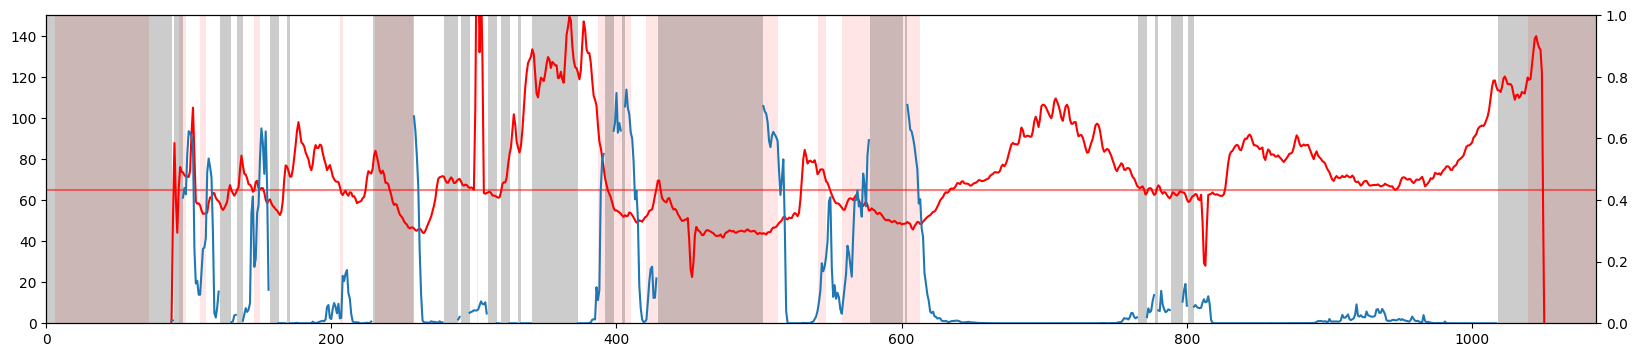

6117	0.1529624492197061	


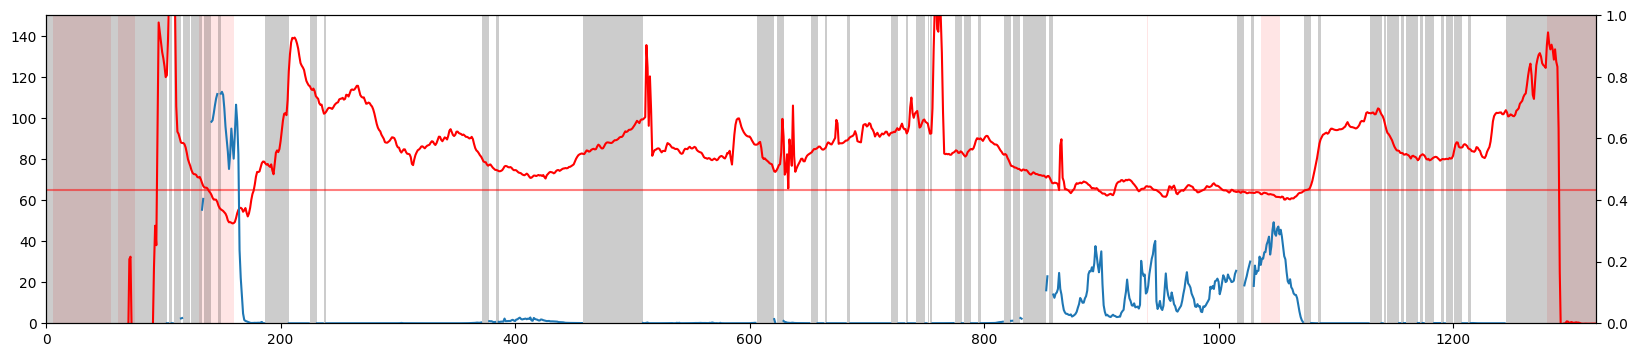

6250	0.07374221506086938	


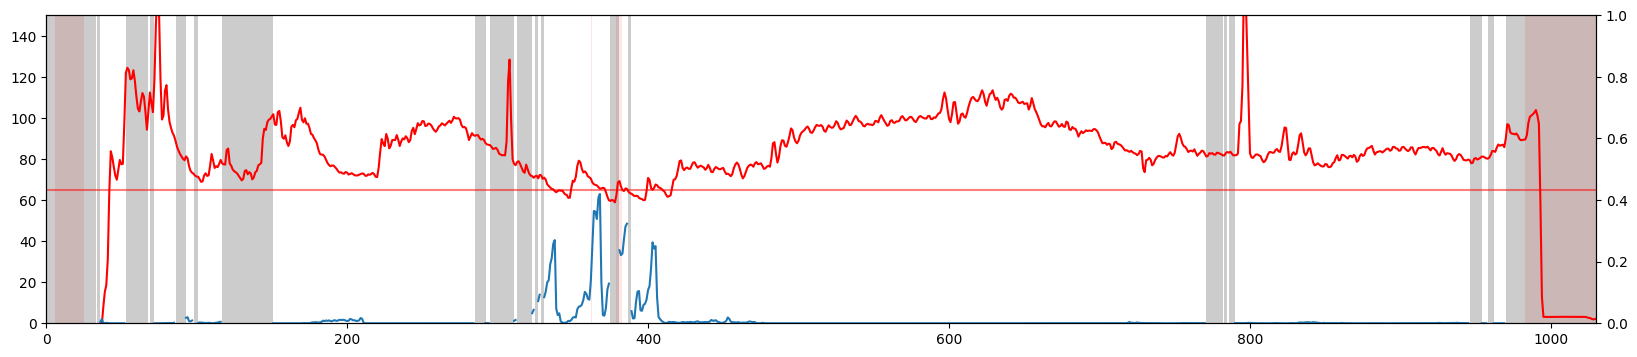

6388	0.2158775253755621	


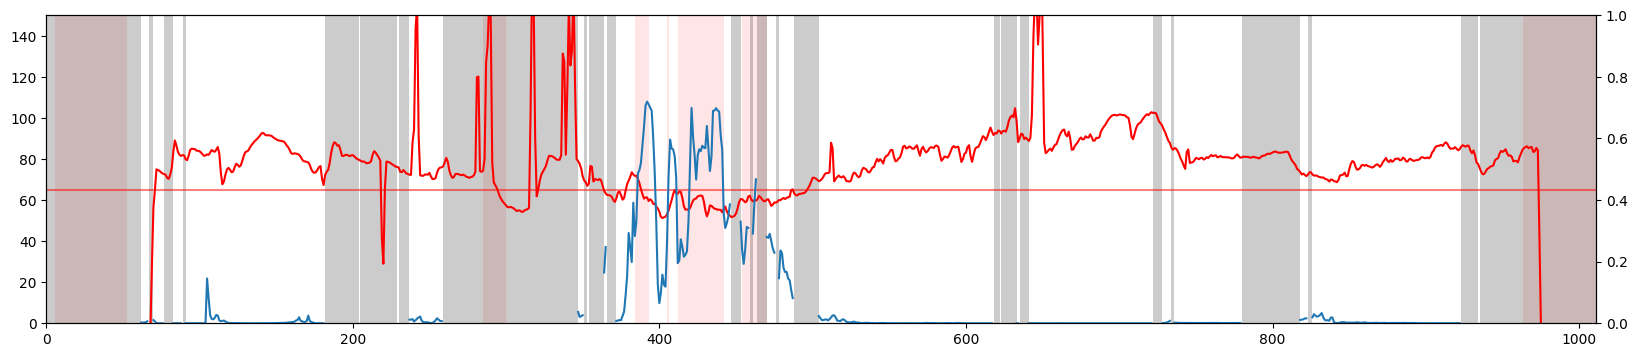

In [16]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()